In [3]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision
import os
import matplotlib.pyplot as plt
from IPython import display as disp
from torch.optim.optimizer import Optimizer, required
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [1255]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_transform = transforms.Compose([
    # Data augmentation
    transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(32, padding=4), 
    # Basic preprocessing
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    # Basic preprocessing only
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=train_transform),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=test_transform),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


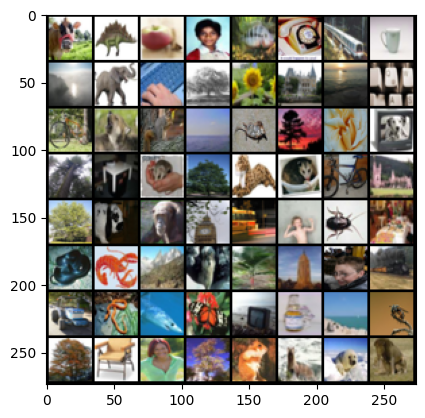

In [1256]:
def unnormalize(image):
    image = image * 0.5 + 0.5  
    image = image.clamp(0, 1)
    return image

plt.rcParams['figure.dpi'] = 100
x, t = next(train_iterator)
x, t = x.to(device), t.to(device)
x = unnormalize(x)
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()


In [ ]:
# Spectral normalization code adapted from:
# https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/master/spectral_normalization.py

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

def one_hot_encode(labels, num_classes=100):
    return torch.eye(num_classes)[labels]


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)
     

In [7]:
## Adaptive Weighting Scheme Method adapted from
## https://github.com/vasily789/adaptive-weighted-gans/blob/main/aw_loss.py

class aw_method():
    def __init__(self, alpha1=0.5, alpha2=0.75, delta=0.05, epsilon=0.05, normalized_aw=True):
        assert alpha1 < alpha2
        self._alpha1 = alpha1
        self._alpha2 = alpha2
        self._delta = delta
        self._epsilon = epsilon
        self._normalized_aw = normalized_aw

    def aw_loss(self, Dloss_real, Dloss_fake, Dis_opt, Dis_Net, real_validity, fake_validity):
        
        Dis_opt.zero_grad()
        
        Dloss_real.backward(retain_graph=True)
        grad_real_tensor = [param.grad.clone() if param.grad is not None else torch.zeros_like(param) for _, param in Dis_Net.named_parameters()]
        grad_real_list = torch.cat([grad.reshape(-1) for grad in grad_real_tensor], dim=0)
        rdotr = torch.dot(grad_real_list, grad_real_list).item() + 1e-4 
        r_norm = np.sqrt(rdotr)

   
        Dis_opt.zero_grad()
        Dloss_fake.backward(retain_graph=True)

        grad_fake_tensor = [param.grad.clone() if param.grad is not None else torch.zeros_like(param) for _, param in Dis_Net.named_parameters()]
        grad_fake_list = torch.cat([grad.reshape(-1) for grad in grad_fake_tensor], dim=0)
        fdotf = torch.dot(grad_fake_list, grad_fake_list).item() + 1e-4 
        f_norm = np.sqrt(fdotf)
        

        Dis_opt.zero_grad()
        rdotf = torch.dot(grad_real_list,grad_fake_list).item()
        fdotr = rdotf
        
        # Real and Fake scores
        rs = torch.mean(torch.sigmoid(real_validity))
        fs = torch.mean(torch.sigmoid(fake_validity))     

        if self._normalized_aw:
            # Implementation of normalized version of aw-method, i.e. Algorithm 1
            if rs < self._alpha1 or rs < (fs - self._delta):
                if rdotf <= 0:
                    # Case 1: 
                    w_r = (1/r_norm) + self._epsilon
                    w_f = (-fdotr/(fdotf*r_norm)) + self._epsilon
                else:
                    # Case 2: 
                    w_r = (1/r_norm) + self._epsilon
                    w_f = self._epsilon
            elif rs > self._alpha2 and rs > (fs - self._delta):
                if rdotf <= 0:
                    # Case 3: 
                    w_r = (-rdotf/(rdotr*f_norm)) + self._epsilon
                    w_f = (1/f_norm) + self._epsilon
                else:
                    # Case 4: 
                    w_r = self._epsilon
                    w_f = (1/f_norm) + self._epsilon
            else:
                # Case 5
                w_r = (1/r_norm) + self._epsilon
                w_f = (1/f_norm) + self._epsilon	
        else:
            # Implementation of non-normalized version of aw-method, i.e. Algorithm 2
            if rs < self._alpha1 or rs < (fs - self._delta):
                if rdotf <= 0:
                    # Case 1: 
                    w_r = 1 + self._epsilon
                    w_f = (-fdotr/fdotf) + self._epsilon
                else:
                    # Case 2: 
                    w_r = 1 + self._epsilon
                    w_f = self._epsilon
            elif rs > self._alpha2 and rs > (fs - self._delta):
                if rdotf <= 0:
                    # Case 3: 
                    w_r = (-rdotf/rdotr) + self._epsilon
                    w_f = 1 + self._epsilon
                else:
                    # Case 4: 
                    w_r = self._epsilon
                    w_f = 1 + self._epsilon
            else:
                # Case 5
                w_r = 1 + self._epsilon
                w_f = 1 + self._epsilon

        # calculating aw_loss
        aw_loss = w_r * Dloss_real + w_f * Dloss_fake

        # updating gradient, i.e. getting aw_loss gradient
        for index, (_, param) in enumerate(Dis_Net.named_parameters()):
            param.grad = w_r * grad_real_tensor[index] + w_f * grad_fake_tensor[index]
    
        return aw_loss

In [8]:
## Conditional Batch Normalization code adapted from
## https://github.com/pytorch/pytorch/issues/8985

class BatchNorm2d(torch.nn.BatchNorm2d):
    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.data.fill_(1.0)
            self.bias.data.zero_()


class CategoricalConditionalBatchNorm(torch.nn.Module):
    # as in the chainer SN-GAN implementation, we keep per-cat weight and bias
    def __init__(self, num_features, num_cats, eps=2e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super().__init__()
        self.num_features = num_features
        self.num_cats = num_cats
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        if self.affine:
            self.weight = torch.nn.Parameter(torch.Tensor(num_cats, num_features))
            self.bias = torch.nn.Parameter(torch.Tensor(num_cats, num_features))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.data.fill_(1.0)
            self.bias.data.zero_()

    def forward(self, input, cats):
        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        out = torch.nn.functional.batch_norm(
            input, self.running_mean, self.running_var, None, None,
            self.training or not self.track_running_stats,
            exponential_average_factor, self.eps)
        if self.affine:
            shape = [input.size(0), self.num_features] + (input.dim() - 2) * [1]
            weight = self.weight.index_select(0, cats).view(shape)
            bias = self.bias.index_select(0, cats).view(shape)
            out = out * weight + bias
        return out

    def extra_repr(self):
        return '{num_features}, num_cats={num_cats}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)

In [9]:
workers = 2
batch_size = 256
image_size = 32
nc = 3
nz = 128
num_classes = 100

# Learning rate for optimizers
Glr = 0.0002
Dlr = 0.0001

#Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

leak = 0.1
w_g = 4


# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, SpectralNorm):
        if hasattr(m.module, 'weight'):
            nn.init.normal_(m.module.weight_bar.data, 0.0, 0.02)

class Generator(nn.Module):
    def __init__(self, ngpu, num_classes):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.num_classes = num_classes
       
        self.conv1 = nn.ConvTranspose2d(128, 128, 4, 1, 0, bias=False)
        self.bn1 = CategoricalConditionalBatchNorm(128, num_classes)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True)

        self.conv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.bn2 = CategoricalConditionalBatchNorm(64, num_classes)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        self.conv3 = nn.ConvTranspose2d(64, 64, 4, 2, 1, bias=False)
        self.bn3 = CategoricalConditionalBatchNorm(64, num_classes)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        self.conv4 = nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False)
        self.bn4 = CategoricalConditionalBatchNorm(32, num_classes)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)

        self.conv5 = nn.ConvTranspose2d(32, 3, kernel_size=1, stride=1, padding=0, bias=False)
        self.tanh = nn.Tanh()
    
    def forward(self, noise, labels):
        x = self.relu1(self.bn1(self.conv1(noise), labels))
        x = self.relu2(self.bn2(self.conv2(x), labels))
        x = self.relu3(self.bn3(self.conv3(x), labels))
        x = self.relu4(self.bn4(self.conv4(x), labels))
  
        x = self.tanh(self.conv5(x))
        return x

    
# Create the generator
netG = Generator(ngpu, num_classes).to(device)
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        # Convolutional layers
        self.conv1 = SpectralNorm(nn.Conv2d(nc, 16, 3, stride=1, padding=1))
        self.conv2 = SpectralNorm(nn.Conv2d(16, 16, 4, stride=2, padding=1))
        self.conv3 = SpectralNorm(nn.Conv2d(16, 32, 3, stride=1, padding=1))
        self.conv4 = SpectralNorm(nn.Conv2d(32, 32, 4, stride=2, padding=1))
        self.conv5 = SpectralNorm(nn.Conv2d(32, 64, 3, stride=1, padding=1))
        self.conv6 = SpectralNorm(nn.Conv2d(64, 64, 4, stride=2, padding=1))
        self.conv7 = SpectralNorm(nn.Conv2d(64, 128, 3, stride=1, padding=1))
        
        # Final discrimination layer (without spectral norm for projection purpose)
        self.fc = nn.Linear(w_g * w_g * 128, 1)
        
        # Embedding layer for class labels
        self.embedding = nn.Embedding(num_classes, w_g * w_g * 128)
        
    def forward(self, x, labels):
        m = x
        m = F.leaky_relu(self.conv1(m), leak)
        m = F.leaky_relu(self.conv2(m), leak)
        m = F.leaky_relu(self.conv3(m), leak)
        m = F.leaky_relu(self.conv4(m), leak)
        m = F.leaky_relu(self.conv5(m), leak)
        m = F.leaky_relu(self.conv6(m), leak)
        m = F.leaky_relu(self.conv7(m), leak)
        
        #Fully connected layer
        m = m.view(-1, w_g * w_g * 128)
        out = self.fc(m)
        
        # Project the class embedding onto the image features
        class_embedding = self.embedding(labels)  # Embed class labels
        projection = (m * class_embedding).sum(1, keepdim=True)  # Dot product
        
        # Return the final discriminator score as the sum of the fc output and the projection
        return out + projection
    
# Create the Discriminator
netD = Discriminator(100).to(device)
netD.apply(weights_init)
print(netD)

netG_numParam = len(torch.nn.utils.parameters_to_vector(netG.parameters()))
netD_numParam = len(torch.nn.utils.parameters_to_vector(netD.parameters()))

print(f'> Number of model parameters {netG_numParam + netD_numParam}')
if netG_numParam + netD_numParam > 1000000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")
    print("Number of Parameters in Generator", netG_numParam)
    print("Number of Parameter in Discriminator", netD_numParam)

# Create batch of latent vectors and labels that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
num_samples = fixed_noise.size(0)  
repeats = (num_samples // num_classes) + 1  
fixed_labels = torch.arange(0, num_classes).repeat(repeats)[:num_samples]
fixed_labels = fixed_labels.to(device)


# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=Glr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=Dlr, betas=(beta1, 0.999))
steps = 0

# Setup adaptive weighting scheme
aw = aw_method(alpha1=0.5, alpha2=0.75, delta=0.05, epsilon=0.05, normalized_aw=True)


Generator(
  (conv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): CategoricalConditionalBatchNorm(128, num_cats=100, eps=2e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): CategoricalConditionalBatchNorm(64, num_cats=100, eps=2e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): CategoricalConditionalBatchNorm(64, num_cats=100, eps=2e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): CategoricalConditionalBatchNorm(32, num_cats=100, eps=2e-05, momen

Starting Training Loop...
Fixed Labels shape torch.Size([64])
Step [0/50000]	Loss_D (aw_loss): 0.4111	Loss_G: -0.0141


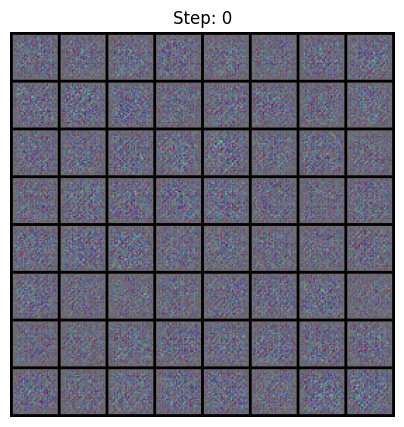

Fixed Labels shape torch.Size([64])
Step [5000/50000]	Loss_D (aw_loss): 0.0641	Loss_G: 1.0934


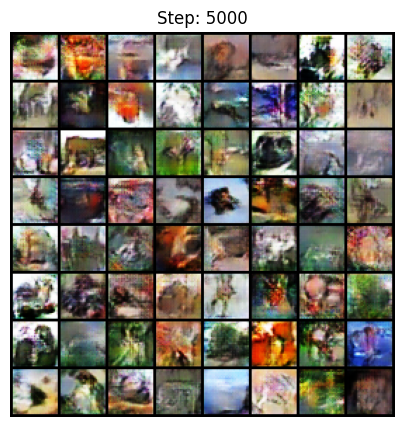

Fixed Labels shape torch.Size([64])
Step [10000/50000]	Loss_D (aw_loss): 0.0541	Loss_G: 1.3936


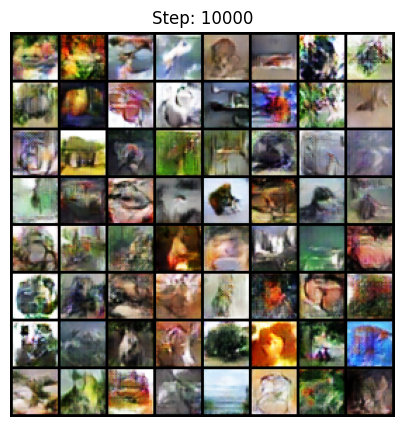

Fixed Labels shape torch.Size([64])
Step [15000/50000]	Loss_D (aw_loss): 0.0560	Loss_G: 1.2215


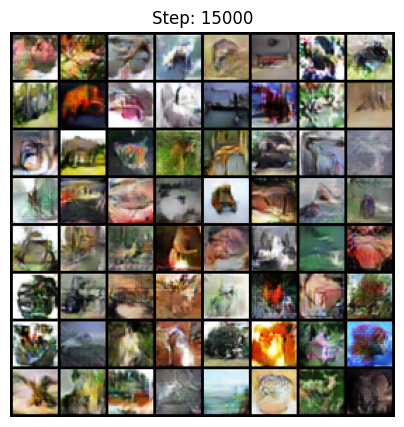

Fixed Labels shape torch.Size([64])
Step [20000/50000]	Loss_D (aw_loss): 0.0714	Loss_G: 1.2251


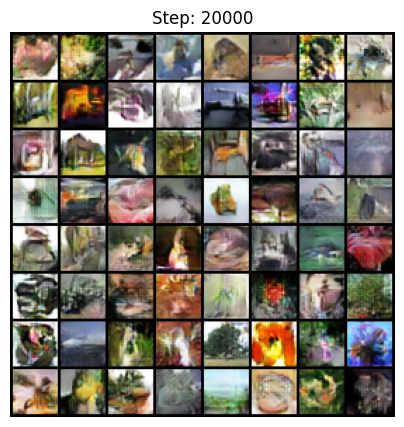

Fixed Labels shape torch.Size([64])
Step [25000/50000]	Loss_D (aw_loss): 0.0590	Loss_G: 1.3072


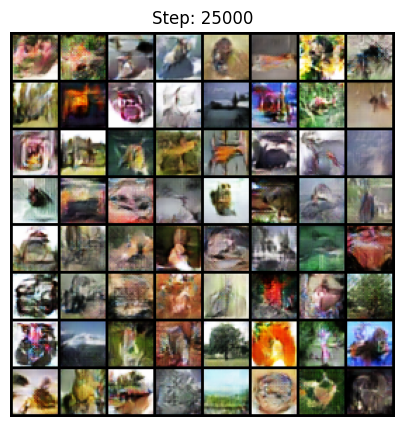

Fixed Labels shape torch.Size([64])
Step [30000/50000]	Loss_D (aw_loss): 0.0534	Loss_G: 1.8332


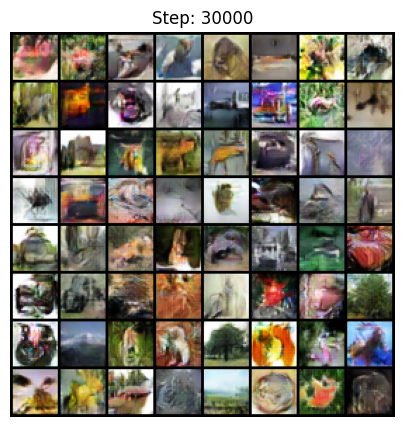

Fixed Labels shape torch.Size([64])
Step [35000/50000]	Loss_D (aw_loss): 0.0578	Loss_G: 0.9210


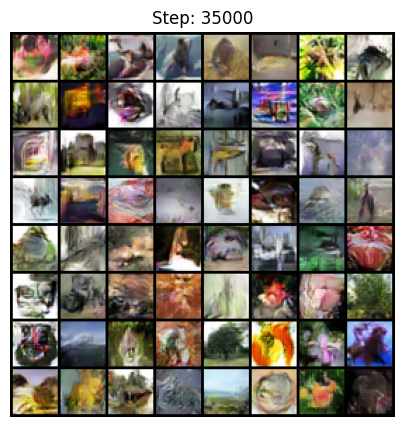

Fixed Labels shape torch.Size([64])
Step [40000/50000]	Loss_D (aw_loss): 0.0515	Loss_G: 1.9033


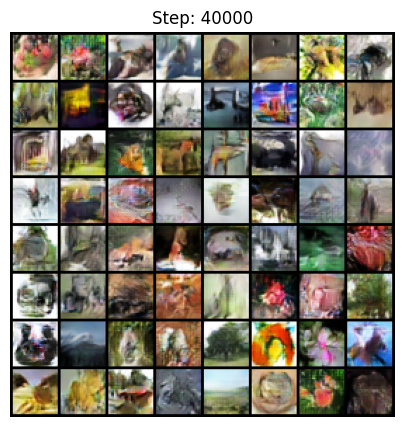

Fixed Labels shape torch.Size([64])
Step [45000/50000]	Loss_D (aw_loss): 0.0538	Loss_G: 1.1825


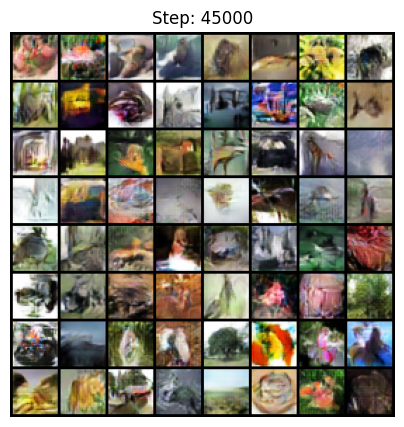

Fixed Labels shape torch.Size([64])
Step [50000/50000]	Loss_D (aw_loss): 0.0506	Loss_G: 1.9403


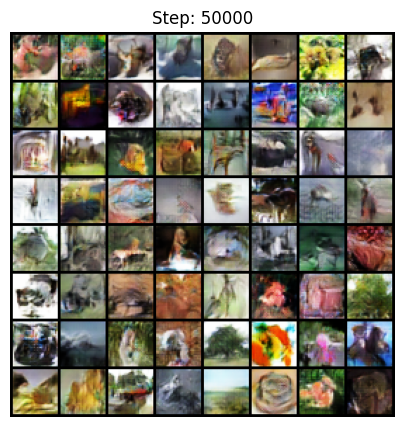

Training finished.


In [64]:
#Training
import torch
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim

# Initialize step counter and lists to track progress
steps = 0
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")

# Training Loop
while steps < 50000:
    for i, data in enumerate(train_loader, 0):
        if steps > 50000:
            break

        ############################
        ##    Update D network    ##
        ############################
       
        netD.zero_grad()
        
        real_images, labels = data
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        # Convert labels
        labels = labels.to(device) 
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise, labels)
        
        # Update discriminator with real images
        netD.zero_grad()
        output_real = netD(real_images, labels).view(-1)
        errD_real = F.relu(1.0 - output_real).mean()
        
        output_fake = netD(fake_images.detach(), labels).view(-1)
        errD_fake = F.relu(1.0 + output_fake).mean()
        
        #Calculate adaptive weighting scheme loss
        aw_loss = aw.aw_loss(errD_real, errD_fake, optimizerD, netD, output_real, output_fake)
        
        aw_loss.backward()
        optimizerD.step()
        
        ############################
        ##    Update G network    ##
        ############################
        
        netG.zero_grad()
        output = netD(fake_images, labels).view(-1)
        
        #Standard Hinge loss
        errG = -output.mean()
        
        errG.backward()
        optimizerG.step()
        
        G_losses.append(errG.item())
        D_losses.append(aw_loss.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if steps % 5000 == 0 or steps == 0:
            with torch.no_grad():
                print("Fixed Labels shape",fixed_labels.shape)
                fake = netG(fixed_noise, fixed_labels).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            print(f'Step [{steps}/{50000}]\tLoss_D (aw_loss): {aw_loss.item():.4f}\tLoss_G: {errG.item():.4f}')

            # Display the generated images
            plt.figure(figsize=(5,5))
            plt.axis("off")
            plt.imshow(np.transpose(img_list[-1],(1,2,0)))
            plt.title(f"Step: {steps}")
            plt.show()

        steps += 1

print("Training finished.")


In [65]:
# torch.save(netG.state_dict(), 'generator_state_dict_conditional.pth')
# torch.save(netD.state_dict(), 'discriminator_state_dict_conditional.pth')

In [10]:
generator_state_dict = torch.load('generator_state_dict_conditional.pth')
discriminator_state_dict = torch.load('discriminator_state_dict_conditional.pth')

# Apply the state dictionaries to the models
netG.load_state_dict(generator_state_dict)
netD.load_state_dict(discriminator_state_dict)

netG.eval()
netD.eval()

Discriminator(
  (conv1): SpectralNorm(
    (module): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): SpectralNorm(
    (module): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv3): SpectralNorm(
    (module): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): SpectralNorm(
    (module): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv5): SpectralNorm(
    (module): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv6): SpectralNorm(
    (module): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv7): SpectralNorm(
    (module): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (embedding): Embedding(100, 2048)
)

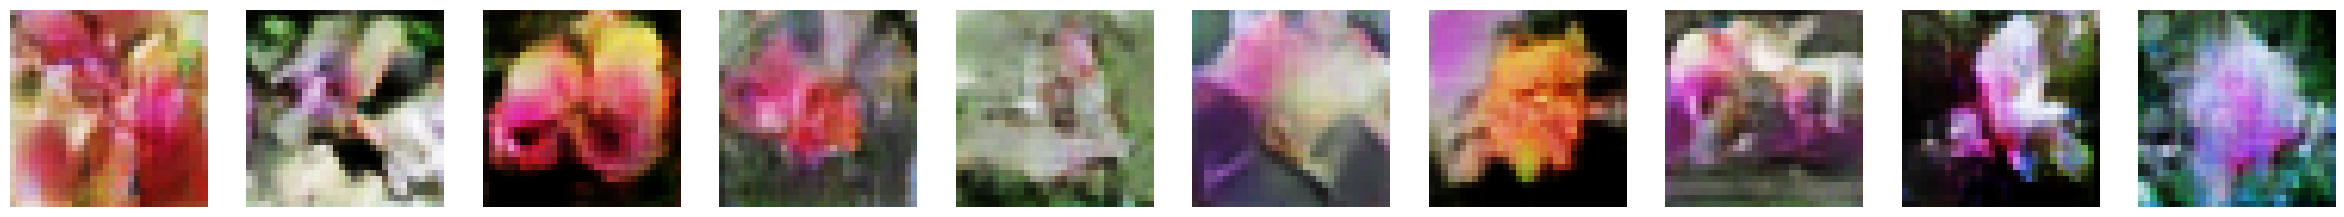

In [1240]:
# Function to generate images based on class name
class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]


def generate_images(class_name, num_images=1):
    # Map the class name to its corresponding label
    class_label = class_names.index(class_name)
    # Convert the class label to a tensor and replicate it for each image you want to generate
    labels = torch.full((num_images,), class_label, dtype=torch.long, device=device)
    
    # Generate random noise
    z = torch.randn(num_images, nz, 1, 1, device=device)
    
    # Generate images
    netG.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        generated_images = netG(z, labels).cpu()

    # Display the images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
    for i, img in enumerate(generated_images):
        img = (img + 1) / 2  # Assuming images were normalized to [-1, 1]
        img = img.clamp(0, 1)
        img = np.transpose(img.numpy(), (1, 2, 0))
        if num_images > 1:
            axs[i].imshow(img)
            axs[i].axis('off')
        else:
            plt.imshow(img)
            plt.axis('off')
    plt.show()
    return z 

# Example usage
latent_vectors = generate_images('orchid', num_images=10)

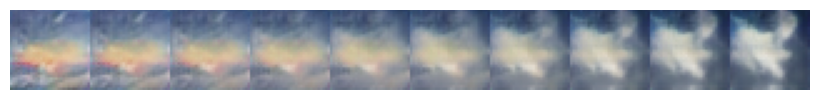

In [865]:
# Create Interpolations based on chosen latent vectors
# Using the previous function we selected high quality images, and their corresponding latent vectors 
# used the following function to create interpolations based on predefined latent vectors

def interpolate(start, end, steps=10):
    """
    Linearly interpolates between two vectors.
    
    Parameters:
    - start: Starting vector.
    - end: Ending vector.
    - steps: Number of interpolation steps including start and end.
    
    Returns:
    - A tensor containing interpolated vectors.
    """
    # Compute weights for each step
    weights = torch.linspace(0, 1, steps=steps, device=start.device)
    
    # Interpolate between start and end
    return (1 - weights.view(-1, 1, 1, 1)) * start + weights.view(-1, 1, 1, 1) * end

num_steps = 10  # Number of steps in the interpolation
interpolated_vectors = interpolate(rocket, rocket2, steps=num_steps)
class_label = torch.full((num_steps,), class_names.index('cloud'), dtype=torch.long, device='cuda')


with torch.no_grad():
    interpolated_images = netG(interpolated_vectors, class_label).cpu()  # Generates a batch of images

# Assuming interpolated_images contains your batch of generated images
# Normalize the interpolated images to [0, 1] if not already done
interpolated_images = (interpolated_images + 1) / 2
interpolated_images = interpolated_images.clamp(0, 1)

# Convert to grid with no padding between images
interpolated_grid_cloud = vutils.make_grid(interpolated_images, nrow=num_steps, padding=0, normalize=False)

# Convert grid to numpy for plotting
np_grid = interpolated_grid_cloud.numpy()

# Adjust figure size for a smaller display
fig_size = (8, 8) if num_steps > 5 else (num_steps, 1)  # Adjust based on number of steps
plt.figure(figsize=fig_size)
plt.imshow(np.transpose(np_grid, (1, 2, 0)))  # Convert from Tensor image
plt.axis('off')

# Tight layout and save the figure
plt.tight_layout(pad=0)
plt.savefig('interpolated_images_grid_cloud.png', bbox_inches='tight', pad_inches=0)
plt.show()

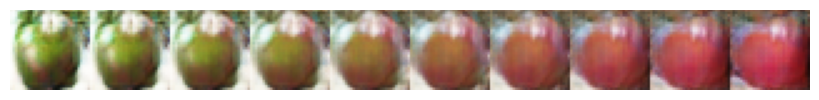

In [671]:
def interpolate(start, end, steps=10):
    """
    Linearly interpolates between two vectors.
    
    Parameters:
    - start: Starting vector.
    - end: Ending vector.
    - steps: Number of interpolation steps including start and end.
    
    Returns:
    - A tensor containing interpolated vectors.
    """
    # Compute weights for each step
    weights = torch.linspace(0, 1, steps=steps, device=start.device)
    
    # Interpolate between start and end
    return (1 - weights.view(-1, 1, 1, 1)) * start + weights.view(-1, 1, 1, 1) * end

num_steps = 10  # Number of steps in the interpolation
interpolated_vectors = interpolate(apple, apple2, steps=num_steps)
class_label = torch.full((num_steps,), class_names.index('apple'), dtype=torch.long, device='cuda')


with torch.no_grad():
    interpolated_images = netG(interpolated_vectors, class_label).cpu()  # Generates a batch of images

# Assuming interpolated_images contains your batch of generated images
# Normalize the interpolated images to [0, 1] if not already done
interpolated_images = (interpolated_images + 1) / 2
interpolated_images = interpolated_images.clamp(0, 1)

# Convert to grid with no padding between images
interpolated_grid_apple = vutils.make_grid(interpolated_images, nrow=num_steps, padding=0, normalize=False)

# Convert grid to numpy for plotting
np_grid = interpolated_grid_apple.numpy()

# Adjust figure size for a smaller display
fig_size = (8, 8) if num_steps > 5 else (num_steps, 1)  # Adjust based on number of steps
plt.figure(figsize=fig_size)
plt.imshow(np.transpose(np_grid, (1, 2, 0)))  # Convert from Tensor image
plt.axis('off')

# Tight layout and save the figure
plt.tight_layout(pad=0)
plt.savefig('interpolated_images_grid_apple.png', bbox_inches='tight', pad_inches=0)
plt.show()

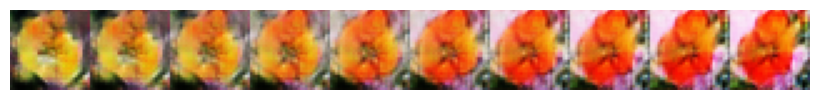

In [670]:
def interpolate(start, end, steps=10):
    """
    Linearly interpolates between two vectors.
    
    Parameters:
    - start: Starting vector.
    - end: Ending vector.
    - steps: Number of interpolation steps including start and end.
    
    Returns:
    - A tensor containing interpolated vectors.
    """
    # Compute weights for each step
    weights = torch.linspace(0, 1, steps=steps, device=start.device)
    
    # Interpolate between start and end
    return (1 - weights.view(-1, 1, 1, 1)) * start + weights.view(-1, 1, 1, 1) * end

num_steps = 10  # Number of steps in the interpolation
interpolated_vectors = interpolate(poppy, poppy2, steps=num_steps)
class_label = torch.full((num_steps,), class_names.index('poppy'), dtype=torch.long, device='cuda')


with torch.no_grad():
    interpolated_images = netG(interpolated_vectors, class_label).cpu()  # Generates a batch of images

# Assuming interpolated_images contains your batch of generated images
# Normalize the interpolated images to [0, 1] if not already done
interpolated_images = (interpolated_images + 1) / 2
interpolated_images = interpolated_images.clamp(0, 1)

# Convert to grid with no padding between images
interpolated_grid_poppy = vutils.make_grid(interpolated_images, nrow=num_steps, padding=0, normalize=False)

# Convert grid to numpy for plotting
np_grid = interpolated_grid_poppy.numpy()

# Adjust figure size for a smaller display
fig_size = (8, 8) if num_steps > 5 else (num_steps, 1)  # Adjust based on number of steps
plt.figure(figsize=fig_size)
plt.imshow(np.transpose(np_grid, (1, 2, 0)))  # Convert from Tensor image
plt.axis('off')

# Tight layout and save the figure
plt.tight_layout(pad=0)
plt.savefig('interpolated_images_grid_poppy.png', bbox_inches='tight', pad_inches=0)
plt.show()

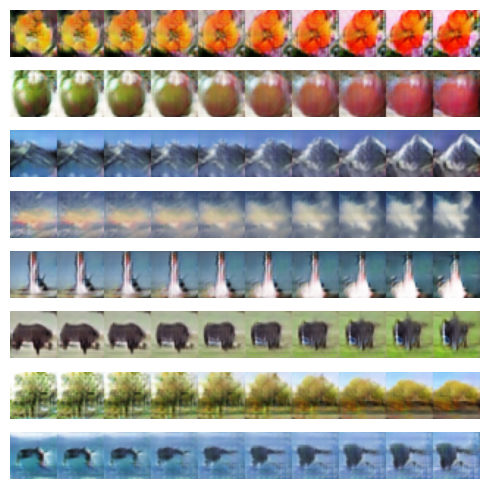

In [902]:
from PIL import Image
# Unable to run as we saved each interpolation separately and the concatenating together in a single image
image_paths = [
    './interpolated_images_grid_poppy.png',
    './interpolated_images_grid_apple.png',
    './interpolated_images_grid_mountain.png',
    './interpolated_images_grid_cloud.png',
    './interpolated_images_grid_rocket.png',
    './interpolated_images_grid_cattle.png',
    './interpolated_images_grid_willow_tree.png',
    './interpolated_images_grid_whale.png',
]

# Load the images into a list
images = [Image.open(path) for path in image_paths]
grid_rows = 8
grid_cols = 1


fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(5, 5))
axes_flat = axes.flatten()
for ax, img in zip(axes_flat, images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes
for ax in axes_flat[len(images):]:
    ax.remove()

    
plt.savefig('./interpolated_images_grid_combined.png', bbox_inches='tight', pad_inches=0)
plt.tight_layout()
plt.show()

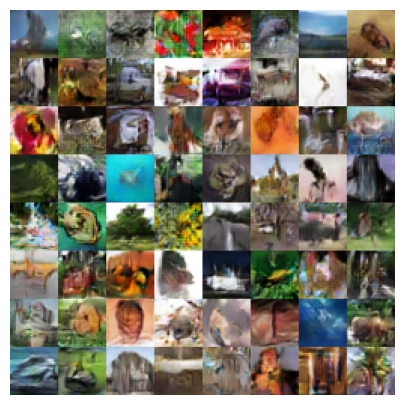

Class names for the generated images:
mountain, skunk, crab, poppy, lobster, bear, plain, camel, bear, possum, bus, bus, bed, table, cockroach, couch, poppy, leopard, clock, tiger, lion, orange, telephone, trout, willow_tree, chimpanzee, shark, chimpanzee, snake, castle, spider, skyscraper, baby, snake, oak_tree, sunflower, road, skunk, cattle, kangaroo, chair, man, orange, train, bridge, butterfly, orchid, bicycle, bridge, hamster, woman, porcupine, hamster, elephant, cloud, cattle, dolphin, lawn_mower, castle, bed, boy, woman, wardrobe, palm_tree


In [1254]:
# Randomly Sample a batch of 64 images from the latent space

num_images = 64  
threshold = 2.0

# Generate random latent vectors
noise = torch.randn(num_images, nz, device='cuda')
noise = noise.view(num_images, nz, 1, 1)

# Generate random labels
labels = torch.randperm(num_classes, device='cuda')[:num_images]

with torch.no_grad():
    # Generate fake images
    fake = netG(noise, labels).detach().cpu()

# Display the generated images
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=0, normalize=True), (1,2,0)))
plt.savefig('./sampled_batch_64.png', bbox_inches='tight', pad_inches=0)
plt.show()

label_indices = labels.cpu().numpy()

# Print out the corresponding class names for each generated image
class_names_str = ', '.join([class_names[index] for index in label_indices])

print("Class names for the generated images:")
print(class_names_str)

In [1275]:
#Calculate LPIPs score

import lpips

dataiter = iter(train_loader)
real_images, real_labels = next(dataiter)
lpips_model = lpips.LPIPS(net='alex').to('cuda')

def compute_similarity(real_images, fake_images, model):
    similarities = []
    for real_img, fake_img in zip(real_images, fake_images):
        real_img = real_img.unsqueeze(0).to('cuda')  # Add batch dim and send to GPU
        fake_img = fake_img.unsqueeze(0).to('cuda')
        sim = model(real_img, fake_img)
        similarities.append(sim.item())
    return similarities

similarities = compute_similarity(real_images, fake, lpips_model)
average_similarity = sum(similarities) / len(similarities)
print(f'Average LPIPS similarity: {average_similarity}')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home2/nfqn37/jupyter/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Average LPIPS similarity: 0.2396507040830329


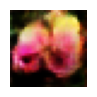

In [1248]:
#CHERRY PICKED IMAGE 1

# chosenvector4 = latent_vectors[2]
class_label = class_names.index('orchid')
class_label = torch.tensor([class_label], dtype=torch.long, device='cuda')  # Adds a batch dimension
chosenvector4 = chosenvector4.view(1, -1, 1, 1)

with torch.no_grad():
    # Generate the chosen image
    generated_image = netG(chosenvector4, class_label).detach().cpu()

# Prepare the image for display
generated_image_np = generated_image.squeeze(0).numpy()  # Remove the batch dimension
generated_image_np = np.transpose(generated_image_np, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
generated_image_np_orchid = (generated_image_np - generated_image_np.min()) / (generated_image_np.max() - generated_image_np.min())  # Normalize to [0, 1] for displaying

# Display the image
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(generated_image_np_orchid)

pickup_truck


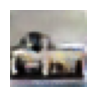

In [1244]:
#CHERRY PICKED IMAGE 2

# chosen_noise_vector2 = noise[25].unsqueeze(0) 
# chosen_label_index2 = torch.tensor([label_indices[25]], device='cuda')  

with torch.no_grad():
    # Generate the chosen image
    generated_image = netG(chosen_noise_vector2, chosen_label_index2).detach().cpu()

# Prepare the image for display
generated_image_np = generated_image.squeeze(0).numpy()  
generated_image_np = np.transpose(generated_image_np, (1, 2, 0))  
generated_image_np_truck = (generated_image_np - generated_image_np.min()) / (generated_image_np.max() - generated_image_np.min())  

# Display the image
print(class_names[chosen_label_index2])
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(generated_image_np_truck)
plt.show()


orange


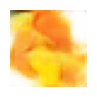

In [1245]:
#CHERRY PICKED IMAGE 3

# chosen_noise_vector = noise[9].unsqueeze(0)  
# chosen_label_index = torch.tensor([label_indices[9]], device='cuda')  

with torch.no_grad():
    # Generate the chosen image
    generated_image = netG(chosen_noise_vector, chosen_label_index).detach().cpu()

# Prepare the image for display
generated_image_np = generated_image.squeeze(0).numpy()  
generated_image_np = np.transpose(generated_image_np, (1, 2, 0)) 
generated_image_np_orange = (generated_image_np - generated_image_np.min()) / (generated_image_np.max() - generated_image_np.min())  

# Display the image
print(class_names[chosen_label_index])
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(generated_image_np_orange)
plt.show()



woman


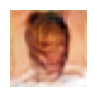

In [1246]:
#CHERRY PICKED IMAGE 4

label_indices = xlabels.cpu().numpy()
chosen_noise_vector3 = xnoise[50].unsqueeze(0) 
chosen_label_index3 = torch.tensor([label_indices[50]], device='cuda')
with torch.no_grad():
    # Generate the chosen image
    generated_image = netG(chosen_noise_vector3, chosen_label_index3).detach().cpu()

# Prepare the image for display
generated_image_np = generated_image.squeeze(0).numpy()  
generated_image_np = np.transpose(generated_image_np, (1, 2, 0))  
generated_image_np_woman = (generated_image_np - generated_image_np.min()) / (generated_image_np.max() - generated_image_np.min())  

# Display the image
print(class_names[chosen_label_index3])
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(generated_image_np_woman)
plt.show()

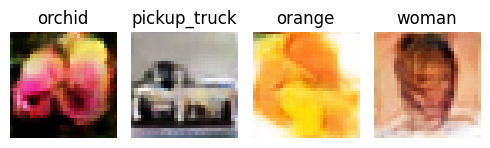

In [1252]:
#DISPLAY CHERRY PICKED IMAGES
fig, axs = plt.subplots(1, 4, figsize=(5, 5))  # Adjust figsize to suit your needs

# Display each image
axs[0].imshow(generated_image_np_orchid)  # First image
axs[0].set_title(class_names[class_names.index('orchid')])
axs[0].axis('off')

axs[1].imshow(generated_image_np_truck)  # Second image
axs[1].set_title(class_names[class_names.index('pickup_truck')])
axs[1].axis('off')

axs[2].imshow(generated_image_np_orange)  # Third image
axs[2].set_title(class_names[class_names.index('orange')])
axs[2].axis('off')

axs[3].imshow(generated_image_np_woman)  # Fourth image
axs[3].set_title(class_names[class_names.index('woman')])
axs[3].axis('off')

plt.tight_layout()
plt.savefig('./cherry_picked.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [1251]:
# CALCULATE FID SCORE #
import os
from torchvision.utils import save_image
from torchvision.datasets import CIFAR100
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import DataLoader
from cleanfid import fid
from tqdm import tqdm  

# Parameters
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000  

def setup_directory(directory):
    if os.path.exists(directory):
        os.system(f"rm -rf {directory}")
    os.makedirs(directory)

setup_directory(real_images_dir)
setup_directory(generated_images_dir)

netG = netG.to(device)
netG.eval()

print("Generating images...")
for _ in tqdm(range(num_samples), desc="Generating images"):
    z = torch.randn(1, nz, 1, 1, device=device)
    # Randomly select a class label
    random_label = torch.randint(0, num_classes, (1,), dtype=torch.long, device=device)
    with torch.no_grad():
        image = netG(z, random_label)
    save_image(image, os.path.join(generated_images_dir, f"gen_random_{random_label.item()}_{_}.png"))


print("Saving real images...")
num_saved_real = 0
for real_samples_batch, labels_batch in tqdm(test_iterator, desc="Saving real images", total=num_samples):
    for image, label in zip(real_samples_batch, labels_batch):
        if num_saved_real >= num_samples:
            break
        save_image(image, os.path.join(real_images_dir, f"real_class_{label.item()}_{num_saved_real}.png"))
        num_saved_real += 1
    if num_saved_real >= num_samples:
        break

# Compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")

Generating images...


Generating images: 100%|██████████| 10000/10000 [00:39<00:00, 256.02it/s]


Saving real images...


Saving real images:   0%|          | 19/10000 [00:26<3:52:13,  1.40s/it]


compute FID between two folders


/home2/nfqn37/jupyter/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Found 10000 images in the folder real_images_CSNGAN


FID real_images_CSNGAN : 100%|██████████| 313/313 [01:06<00:00,  4.72it/s]


Found 10000 images in the folder generated_images_CSNGAN


FID generated_images_CSNGAN : 100%|██████████| 313/313 [01:03<00:00,  4.95it/s]


FID score: 38.266052724143265
